In [1]:
import sys
import os
import numpy as np
from PIL import Image
from PIL import ImageOps
import cv2
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import xml.etree.ElementTree as ET
from xml.dom import minidom
import pandas as pd
from skimage import draw
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, shape
import geojson
import argparse
from shapely.ops import cascaded_union, unary_union
from pathlib import Path

In [2]:
def create_dir_if_not_exists(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' created.")
    else:
        print(f"Directory '{dir_path}' already exists.")


In [3]:
def extract_tile_start_end_coords(all_tile, deepzoom_lvl, x_loc, y_loc):
    #Get coords
    tile_coords = all_tile.get_tile_coordinates(deepzoom_lvl, (x_loc, y_loc))

    #Get top left pixel coordinates
    topleft_x = tile_coords[0][0]
    topleft_y = tile_coords[0][1]

    #Get level (original)
    o_lvl = tile_coords[1]

    #Get downsample factor
    ds_factor = all_tile._l0_l_downsamples[o_lvl] #downsample factor

    #Get region size in current level 
    rsize_x = tile_coords[2][0] 
    rsize_y = tile_coords[2][1] 

    #Get tile starts and end   
    start_loc = tile_coords[0] #start
    end_loc = (int(topleft_x + ds_factor * rsize_x), int(topleft_y + ds_factor* rsize_y)) #end

    #Get save coord name (first two is the starting loc, and the last two are the x and y size considering dsfactor)
    coord_name = str(topleft_x) + "-" + str(topleft_y) + "_" + '%.0f' % (ds_factor * rsize_x) + "-" + '%.0f' % (ds_factor * rsize_y)
    
    return start_loc, end_loc, coord_name

In [4]:
def save_to_disk(tile_pull, save_coords, lvl, tile_label, tile_size, physSize, save_location,save_name):

    if 'cancer' in tile_label:
        tile_mask = tile_label['cancer']
    elif 'benign' in tile_label:
        tile_mask = tile_label['benign']
        
    tile_mask = tile_mask.astype(bool)
    mask_pull = Image.fromarray(tile_mask)
    # edge tiles will not be correct size (too small), so we reflect image data until correct size
    if tile_size[0]<physSize or tile_size[1]<physSize:
        # tile_pull = Image.fromarray(cv2.copyMakeBorder(np.array(tile_pull), 0, physSize - int(tile_size[1]), 0, physSize - int(tile_size[0]),cv2.BORDER_REFLECT))
        # mask_pull = Image.fromarray(cv2.copyMakeBorder(tile_mask, 0, physSize - int(tile_size[1]), 0,physSize - int(tile_size[0]), cv2.BORDER_REFLECT))
        return
    else:
        # check whitespace amount
        ws = whitespace_check(im=tile_pull)
        if ws < 0.95:
            mask_np = np.array(mask_pull)
            #if benign is the label, change the original mask to all 0s
            if 'benign' in tile_label:
                mask_np.fill(0) 

            tumorperc = (mask_np == True).sum()/(mask_pull.size[0]*mask_pull.size[1])
            mask_np = mask_np.astype('uint8')
            mask_save = Image.fromarray(mask_np)
            tile_savename = save_name + "_" + str(lvl) + "_" \
                            + save_coords + "_" \
                            + "ws-" + '%.2f' % (ws) \
                            + "_tumor-" + '%.2f' % (tumorperc)
            tile_pull = tile_pull.resize(size=(save_image_size, save_image_size), resample=Image.LANCZOS)
            mask_save = mask_save.resize(size=(save_image_size, save_image_size), resample=Image.LANCZOS)
            tile_pull.save(os.path.join(save_location, tile_savename + ".png"))
            mask_save.save(os.path.join(save_location, tile_savename + "_mask.png"))
    return

In [119]:
def assign_label_new2(tile_starts,tile_ends,path):
    ''' calculates overlap of tile with xml regions and creates dictionary based on unique labels '''

    tile_box = [tile_starts[0],tile_starts[1]],[tile_starts[0],tile_ends[1]],[tile_ends[0],tile_starts[1]],[tile_ends[0],tile_ends[1]]
    tile_box = list(tile_box)
    tile_box = MultiPoint(tile_box).convex_hull

    with open(path) as f:
        allobjects = geojson.load(f)

    # Added1023: Filter out objects without a classification
    # Note: checked OPX024, there is one repelicate annotation without label
    allobjects = [obj for obj in allobjects if 'classification' in obj['properties']]
 
    allshapes = [shape(obj["geometry"]) for obj in allobjects]
    alllabels = [obj['properties'] for obj in allobjects]
    roilabels = list()
    for roi_num in range(0,len(alllabels)):
        try:
            roi_label = alllabels[roi_num]['classification']['name']
        except :
            roi_label = 'Tumor'
        roilabels.append(roi_label)

    tile_label = {}
    for label in np.unique(roilabels):
        # loop over every region associated with a given label, sum the overlap
        box_label = False  # initialize
        ov = 0  # initialize
        ov_mask = np.zeros((int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0])),
                            int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0]))), dtype=int)
        for roi_num in range(0,len(alllabels)):
            if roilabels[roi_num] == label:
                roi = allshapes[roi_num]
                if tile_box.intersects(roi):
                    box_label = True
                    ov_reg = tile_box.intersection(roi)
                    ov += ov_reg.area / tile_box.area

                    if ov_reg.geom_type == 'Polygon':
                        reg_mask = poly2mask(
                            vertex_row_coords=[x - min(tile_box.exterior.xy[1]) for x in ov_reg.exterior.xy[1]],
                            vertex_col_coords=[x - min(tile_box.exterior.xy[0]) for x in ov_reg.exterior.xy[0]],
                            shape=(int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0])),
                                   int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0]))))
                        # print(reg_mask.shape)
                        ov_mask += reg_mask
                    elif ov_reg.geom_type == 'MultiPolygon':
                        for roii in ov_reg.geoms:
                            reg_mask = poly2mask(
                                vertex_row_coords=[x - min(tile_box.exterior.xy[1]) for x in roii.exterior.xy[1]],
                                vertex_col_coords=[x - min(tile_box.exterior.xy[0]) for x in roii.exterior.xy[0]],
                                shape=(int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0])),
                                       int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0]))))
                            # print(reg_mask.shape)
                            ov_mask += reg_mask

                    # try:
                    #     reg_mask = self.poly2mask(vertex_row_coords=[x - min(tile_box.exterior.xy[1]) for x in ov_reg.exterior.xy[1]],
                    #                    vertex_col_coords=[x - min(tile_box.exterior.xy[0]) for x in ov_reg.exterior.xy[0]],
                    #                    shape=(int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0])),
                    #                           int(max(tile_box.exterior.xy[0]) - min(tile_box.exterior.xy[0]))))
                    #     # print(reg_mask.shape)
                    #     ov_mask += reg_mask
                    # except AttributeError:
                    #     print(" !!!!!!!!!!!!!!  ATTRIBUTE ERROR !!!!!!!!!!!!!!! " + label + " " + '%.2f' % (ov))
        if box_label == True:
            tile_label[label] = ov_mask

    # # p.s. if you are curious, you can plot the polygons by the following
    # for polygon in roi.geoms:
    #     plt.plot(*polygon.exterior.xy) and plt.plot(*tile_box.exterior.xy)
    
    return tile_label

In [6]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    ''''''
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=int)
    mask[fill_row_coords, fill_col_coords] = 1
    return mask

In [7]:
def whitespace_check(im):
    bw = im.convert('L')
    bw = np.array(bw)
    bw = bw.astype('float')
    bw=bw/255
    prop_ws = (bw > 0.8).sum()/(bw>0).sum()
    return prop_ws

In [9]:
proj_dir = '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/'
csv_location =  proj_dir + '/intermediate_data/cd_finetune/ccola_opx_retrain_alldata_list.csv' 
json_location = proj_dir + '/intermediate_data/cd_finetune/ccola_opx_annotations/' 
save_path = proj_dir + '/intermediate_data/cd_finetune/cancer_detection_training/patches/'
mag_extract = [20] # specify which magnifications you wish to pull images from
save_image_size = 250  # specify image size to be saved (note this is the same for all magnifications)
pixel_overlap = 0       # specify the level of pixel overlap in your saved images
limit_bounds = True     # this is weird, dont change it
write_all = False       # default is to only write patches that overlap with xml regions (if no xml provided, all patches written)
nolabel = False         # if all regions in an annotation file belong to the same class, they are labeled as 'tumor'
                             #      nolabel=FALSE should only be used if the "Text" attribute in xml corresponds to label


In [10]:
df = pd.read_csv(csv_location)
flist = df['filename']
pathlist = df['filepath']

In [126]:
f = 8
_file = os.path.join(pathlist[f], flist[f])
print(_file)

/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/data/OPX/OPX_057.tif


In [127]:
#Get slide
oslide = openslide.OpenSlide(_file)

#Get names
save_name = str(Path(os.path.basename(_file)).with_suffix(''))
json_file = save_name + '.json' #json file name

In [16]:
#Create individual dir
ind_save_path = os.path.join(save_path,save_name)
create_dir_if_not_exists(ind_save_path)

Directory '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred//intermediate_data/cd_finetune/patches_and_masks/OPX_024' already exists.


In [128]:
# this is physical microns per pixel
acq_mag = 10.0/float(oslide.properties[openslide.PROPERTY_NAME_MPP_X])

# this is nearest multiple of 20 for base layer
base_mag = int(20 * round(float(acq_mag) / 20))
print(base_mag)

# this is how much we need to resample our physical patches for uniformity across studies
physSize = round(save_image_size*acq_mag/base_mag)

# grab tiles accounting for the physical size we need to pull for standardized tile size across studies
tiles = DeepZoomGenerator(oslide, tile_size=physSize-round(pixel_overlap*acq_mag/base_mag), overlap=round(pixel_overlap*acq_mag/base_mag/2), limit_bounds=limit_bounds)

# calculate the effective magnification at each level of tiles, determined from base magnification
tile_lvls = tuple(base_mag/(tiles._l_z_downsamples[i]*tiles._l0_l_downsamples[tiles._slide_from_dz_level[i]]) for i in range(0,tiles.level_count))


40


In [129]:
x_tiles, y_tiles = tiles.level_tiles[tile_lvls.index(lvl)]
print(x_tiles, y_tiles)

132 199


In [24]:
# pull tiles from levels specified by self.mag_extract
for lvl in mag_extract:
    if lvl in tile_lvls:
        x_tiles, y_tiles = tiles.level_tiles[tile_lvls.index(lvl)]
        print(x_tiles, y_tiles)
        for y in range(0, y_tiles):
            for x in range(0, x_tiles):
                #grab tile coordinates
                tile_starts, tile_ends, save_coords = extract_tile_start_end_coords(tiles, tile_lvls.index(lvl), x, y)

                #Get tile labels
                tile_labels = assign_label_new2(tile_starts,tile_ends,os.path.join(json_location, json_file))

                if not tile_labels:
                    pass
                else:
                    print(x,y)
                    #print(tile_labels)
                    tile_size = tiles.get_tile_dimensions(tile_lvls.index(lvl), (x, y))
                    tile_pull = tiles.get_tile(tile_lvls.index(lvl), (x, y))
                    save_to_disk(tile_pull=tile_pull, save_coords=save_coords, lvl=lvl, tile_label=tile_labels, tile_size=tile_size, physSize=physSize, save_location= ind_save_path, save_name = save_name)

    else:
        print("WARNING: YOU ENTERED AN INCORRECT MAGNIFICATION LEVEL")

164 189


KeyboardInterrupt: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


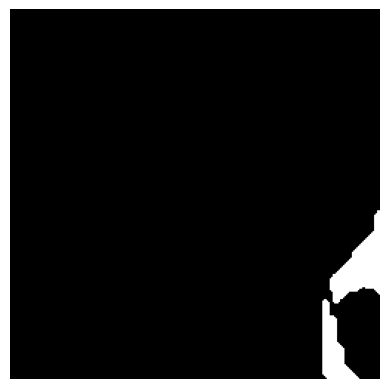

1

In [138]:
#check output mask
image = Image.open(save_path + 'OPX_010/' + 'OPX_010_20_18000-23000_500-500_ws-0.02_tumor-0.03_mask.png')
image_array = np.array(image)
print(image_array)
plt.imshow(image_array,cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
image_array.max()


In [ ]:
#exame img
image = Image.open(save_path + 'OPX_010/' + 'OPX_010_20_18000-23000_500-500_ws-0.02_tumor-0.03.png')
image_array = np.array(image)
plt.imshow(image_array)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
image_array[:,:,0]
image_array[:,:,1]
image_array[:,:,2]
plt.imshow(image_array[:,:,2])
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


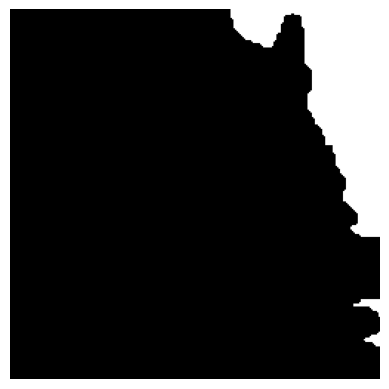

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [136]:
#check output mask
image = Image.open('/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/intermediate_data/cd_finetune/cancer_detection_training_example/patches/TMA97A-8-10_20_0-2500_ws-0.42_tumor-0.11_mask.png')
image_array = np.array(image)
print(image_array)
plt.imshow(image_array,cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
image_array.max()
image_array